In [10]:
#| default_exp learner

In [11]:
import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

<span style='color:Blue'> 
NB: JH made several changes to the code AFTER the lesson where this was presented.
To find those changes (made to the code in the last week), we 
can go to the course repo, add /compare in GitHub,  and then we can compare across different things.
One of the examples they provide is to compare across different times, e.g., 
the master Branch now versus one day ago.
To change that to vs. 7 days ago, change in the URL to 7.
This way we can see all the commits, the changes from last week. 
</span>

In [12]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [13]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

### Preliminaries
From previous notebooks.

In [14]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
x,y = ds_builder.info.features
x, y

('image', 'label')

In [15]:
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

We define an `@inplace` transform `transformi(b)`
that converts each image `o in b[x]` into a tensor with `TF.to_tensor(o)`.
<br>
`tds` is the transformed dataset dictionary, via `dsd.with_transform(transformi)`

In [16]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

tds = dsd.with_transform(transformi)

`class DataLoaders:` defined similar to before.
We pass 2 dataloaders `dls[:2]` and store them in `.train`, `.valid`.
<br>
We define a `@classmethod` `from_dd`, that calls `DataLoader` on each of the `ds` 
(dataset dictionary items), with the `batch_size` and instantiate our class.
<br>
`@classmethod` allows us to later write `DataLoaders.`something, e.g., `DataLoaders.from_dd`.
<mark > To construct this we could have put this in `init()`, 
but lets start by getting the basic structure.?? 
</mark> 
Nothing on the device because that didn't work (previous notebook).

In [17]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds), **kwargs) for ds in dd.values()])

In [18]:
bs = 1024
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

### Basic Learner

A simple learner that fits on one screen and replaces our `fit` function.
<mark> A learner is something that is going to train or learn a particular model,
using a particular set of data loaders, a particular loss function, a particular learning rate, a particular Optimizer, or some particular optimization function. </mark> <br>
To avoid the boilerplate of storing each of these items separately, we call `fc.store_attr()` in `__init__`.
```Python
 def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
```
Lets look first at the `fit()` method.
```Python
   def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)
```            
It has `self.accs` for keeping track of accuracy (for classification where we can use accuracy),
`self.losses`, etc.
We put the model on the `def_device`, create the optimizer,
store how many `n_epochs` we're going through.
Then for each `epoch` we call the `one_epoch` function, 
either to do train (`True`) or evaluation (`False`).

```Python
def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
```
In `one_epoch` we set `model.training` to training/valid mode, 
and then set `dl` to use the `train` or `valid` set accordingly.  
Then we go through each `batch` in the `dl` dataloader and call `one_batch()`.
```Python
def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
```
`one_batch()` saves the `xb` and `yb` parts of the batch, 
calls the `.model` saving the results in `.preds`, 
calls the loss function `loss_func` with the `.preds` and targets `yb`.
If `model.training` do the backward pass.
Calculate the statistics for our accuracy, and at the end of the epoch print that.

This basic learner is not very flexible but it did something good.
It's not going to help us, for example, with our Autoencoder because there's no
way of changing which things are used for predicting with or for calculating with.
We can use it ONLY for things that involve accuracy with a multi-class classification.
It's a start, all on one screen (31 LoCs), to see what a basic learner is.

In [19]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

Lets create a simple model to test the (basic) Learner.

In [20]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.1852194010416666 0.59565
0 False 1.1349697544642856 0.6088142857142858


## Callbacks

Default exceptions to be ignored.

In [21]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

Note that in `class Callback(): order = 0`
so all callbacks have the default order of zero unless we ask otherwise.

In [22]:
#|export
class Callback(): order = 0

`run_cbs` will run all the `cb` callbacks in `cbs` in `order`.
It uses `getattr()` to retrieve the `method` name in the `cb`.
(`getattr`: Get a named attribute from an object; `getattr(x, 'y')` is equivalent to `x.y`).
If the method exists, it calls it.

NB: An earlier version of this notebook, was putting the learner object itself into self.learn in each callback.
That meant we were referring to, e.g., `self.learn.model`, `self.learn.opt`, etc. 
As it was ugly, JH modified this to instead pass in the learner `learn` as an argument
when it calls the `run_cbs`.
As it passes the learner as a parameter to the method, the learner no longer 
needs to go through the callbacks and set a `.learn` attribute.
Now we have to put `learn` as an argument in all of the Callback methods.
For example, `deviceCB` has a `before_fit`, so now it's got ( ..,learn).
Also we avoid a cycle, where the learner has a reference to the callbacks and 
also the callbacks have a reference back to the learner.

In [23]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

### Simple Callback CompletionCB
Before we look at how callbacks work, let's just run a simple callback `CompletionCB`. 
Before we start fitting a new model it will set its `count` attribute to 0.
After each batch it will increment `count`, and after completing the fitting process
it will print out `count`, how many batches we've done.

In [24]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

(Before we even train a model) lets run manually `before_fit`,
`after_batch`, and `after_fit` using `run_cbs`, to make sure they work as we want.
We set the list of `cbs` to have a single member, `CompletionCB()`.

In [26]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'nonexistent')
run_cbs(cbs, 'after_fit')

Completed 1 batches


As expected, it printed "Completed 1 batches". 
`run_cbs` went through each `cb` in the cbs list. (there's only one),
used `getattr` to find an attribute with the corresponding name, (e.g., `before_fit`),
and called it. Notice how it ignored `nonexistent`,

<mark> NB: **Don't just run code willy-nilly but understand it by experimenting with it. Don't just use what is already created** </mark> <br>
Lets do it all manually: create a callback `cb` set it to `cbs[0]`, just like later in the learner loop.
Q: What happens if we call `getattr` and pass in the `cb` callback?

In [27]:
cbs = [CompletionCB()]
cb = cbs[0]

getattr(cb, 'after_batch', None)

<bound method CompletionCB.after_batch of <__main__.CompletionCB object at 0x12beaac10>>

A: `getattr` returned a method. 
What happens to that method it gets called? let's try calling it.

In [28]:
getattr(cb, 'before_fit', None)(learn)

when we call the `before_fit` it doesn't do anything interesting.
But if we call `after_batch` and then call `after_fit` it does.

In [29]:
getattr(cb, 'after_batch', None)(learn)

getattr(cb, 'after_fit', None)(learn)

Completed 1 batches


## Basic Callbacks Learner

Our previous learner wasn't flexible but it had all the basic pieces: 
a fit method, etc. 
We are hard coding that:
- we can only calculate accuracy and average loss
- we're putting things on a default device
- a single learning rate 

Now lets do an intermediate step: a basic callbacks learner, 
which has nearly all the functionality of the full learner.
After this we're going to create some callbacks and metrics, 
and look at the flexible learner.

The basic callbacks learner is similar to the previous learner:
it's got a `fit()` function which is going to
go through each epoch calling `one_epoch()` with training on and then training off.
`one_epoch` will go through each batch and call `one_batch`, which
will call the model, the loss function and if we're training it will do the backward step.
<mark> And a few more things..</mark>
For example, in `fit()`, after creating the optimizer, 
```Python
self.opt = self.opt_func(self.model.parameters(), self.lr)
```
`self.opt_func` defaults to `SGD`, as `opt_func=optim.SGD`.
We instantiate an SGD object passing in our model's parameters, and the requested learning rate (`lr`).
Before we start looping through `one_epoch` at a time.
```Python
try:
            self.callback('before_epoch')
```           
We first call `self.callback('before_epoch')` which takes a method name.
It calls `run_cbs`, passes in `.cbs` (a list of our callbacks) and the method name.
```Python
def callback(self, method_nm): run_cbs(self.cbs, method_nm)
```
`run_cbs` sort the callbacks in their order attribute and invokes the methods.

In [31]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()
     
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

### Experimenting with exceptions
The `get_model()` function below creates a `nn.Sequential` model.
We instantiate the `model` and the `learn` and call `fit()`. 
Since the only callback we added was `completionCB`, it just reports the number of batches as expected.

In [32]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 69 batches


We now have a trained model, who didn't print any metrics because it does not have any callbacks for that.

`SingleBatchCB(SimpleCB)` after a single batch raises a `cancelEpochException`.
This could be useful if we want to just run one batch to make sure a model works.

(It'll run the final fit?.)

In [33]:
class SingleBatchCB(Callback):
    def after_batch(self, learn): raise CancelEpochException()

We add to `cbs`, the `SingleBatchCB`, and call `fit` to try it.

In [34]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 0 batches


It ran, but nothing happened because it canceled before `CompletionCB()` could run.
We can make `SingleBatchCB` run second by setting its `order` higher, 
e.g., 1 (default order is 0), and `cbs_run` sorts by `order` attribute.

In [37]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelEpochException()

In [38]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 2 batches


**Callbacks** are not "magic", it's just a name we use to refer to callables.
We pass into something that will then call back to that callable at particular times.
There are interesting kinds of callbacks that have multiple methods in them.

## Metrics

Lets define a class `Metric` that can keep track of a metric, e.g., to tell us the accuracy and the loss.
We're going to keep track of all of the actual values that we're averaging and the number in each minibatch.
When we `add` a minibatch we call calculate (`calc`).
A subclass will override the parent classes `calc` so it does the calculation there.
And then we append the result (`last`) to our list of values, `self.vals.append(self.last)`
and append to `ns` (list of batch sizes) the current batch size, `self.ns.append(n)`.

In [27]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

### Accuracy metric
Lets define, for example, an `Accuracy(Metric)` by defining the calculation:
the `mean` of how often the input `inps` equals the targets `targs`.

In [28]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

We create `acc` an `Accuracy` metric object, `add` a few batches of inputs and targets,
and get the `acc.value`, i.e., the accuracy.

In [29]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([1, 1, 2, 0, 1]))
acc.value

tensor(0.63)

Notice that for `acc.value`, because it's a `@property` we didn't have to put parentheses after it to get the calculation to happen.

Another way: create a metric which simply gets the weighted average, 
for example of your loss.
`add` 0.6 is the loss with a batch size of 32; 
`add` 0.9 is a loss and a batch size of 2;
That gives us a weighted average loss of 0.62 which is
equal to the (manual) weighted average calculation.

In [30]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

## Some callbacks to print out, etc

We now need some way to use this metric in a callback to actually print out.
First lets create a `deviceCB(Callback)`, to use a GPU, without the complications we had before,
i.e., to allow multiple processes in the dataloader and also use the GPU device. 

`before_fit()` put the model onto the default device,
and `before_batch()` is run put that batch onto the device.
NB: In the learner everything is put inside self which means it's all modifiable.

We check that the `deviceCB` callback works by using the old learner, replacing `SingleBatchCB()` by  `deviceCB()`.

### Torcheval
We don't have to write every single metric because they
already exist in [torcheval](https://pytorch.org/torcheval/stable/), 
a Pytorch project that we can pip install (not on conda?).
```shell
pip install torcheval
```
`torcheval` has a similar approach to ours, with `.update` and `.compute`. 
They provide a list of metrics to pick from.
As we've already built our own we can now use theirs.

[MulticlassAccuracy](https://pytorch.org/torcheval/stable/generated/torcheval.metrics.MulticlassAccuracy.html#torcheval.metrics.MulticlassAccuracy)

We import the `MulticlassAccuracy` and the `Mean` metrics.<br>
**NB: The following import fails first time, succeeds 2nd time.
so we capture the Error and import again.**
<div style="background-color: #FFB6C1">

File ~/mambaforge/lib/python3.9/site-packages/torcheval/__init__.py:9

-> 152     aten.mm.default: _matmul_flop_jit,

AttributeError: 'builtin_function_or_method' object has no attribute 'default'
</div>

In [32]:
#|export
try: from torcheval.metrics import MulticlassAccuracy
except ImportError:     pass
from torcheval.metrics import MulticlassAccuracy, Mean

We create a `MulticlassAccuracy` metric and we pass in a minibatch of
inputs and targets and then `update` and `compute`.

In [33]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

We call `reset` at the start of each epoch.
After `reset`, `compute` returns `nan` because accuracy is meaningless when we don't have any data yet.

In [34]:
metric.reset()
metric.compute()

tensor(nan)

NB: Some`torcheval` metrics didn't work correctly when tensors were on the GPU and had `requires_grad`.
Created a `to_cpu` function that calls `detach()` to remove 
all the computation history used to calculate a gradient, and also puts the tensor on the CPU.
It'll do the same for dictionaries, lists and tuples of tensors.

In [35]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

### `MetricsCB(Callback)`

For the `MetricsCB(Callback)` we're going to be passing in the names and
objects of the metrics to track and print.
```Python
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
```
As a shortcut, if we didn't want to write `accuracy=` we could just
remove that and run it, and then it will give it a name and
it'll use the same name as the class.
`for o in ms: metrics[type(o).__name__] = o`
We can either pass in `*ms`, will be a tuple,
it's going to be pulled out, so it's just passing a list of positional
arguments which will be turned into a tuple.
Or we can pass in named arguments, will be turned into a dictionary.
If we pass in positional arguments, then we turn them into named arguments in the dictionary 
by grabbing the name from their type.
We'll store that in: `self.metrics = metrics`
And adding manually an additional metric the `loss` as the weighted average of the losses.
`self.all_metrics['loss'] = self.loss = Mean()`

Before fit we tell the learner that we (`self`) are the metrics callback.
`self.learn.metrics = self`.
Before each epoch we reset all of our metrics:
```Python
def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
```
After each epoch we create a dictionary of the keys `k` and values `v` which 
we want to print out, and call `_log` which (for now) just prints them. 
```Python
    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
```
After each batch take the input and target to put them on the CPU.
Then go through each of our `m` metrics and call `m.update`.  
The `update` in the metric says *here's a batch of data*, 
(predictions and targets). 
Then `loss.update` for the special loss metric, passing in the actual loss and the minibatch size.
```Python
def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
```

In [36]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

Below we create `metrics`, a `MetricsCB` object that's going to calculate and print out `accuracy`.
We pass `metrics` as a `cbs` to the `Learner`.
During `learn.fit()`, it's going to print the `accuracy`, `loss`, `epoch` number, and whether it's training or evaluating.

In [37]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [38]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.616', 'loss': '1.159', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.707', 'loss': '0.784', 'epoch': 0, 'train': 'eval'}


## Flexible learner

Using a **context manager** we can make the Learner more sophisticated,
and still fit in a single screen.
<sub><sup>(*JH was going to do it with a decorator but realized a context manager is better.*) </sub></sup>
<br>
We're call our `before_` and `after_` callbacks in a `try except` block,
and use a `with` statement for the callbacks in the block.
One way is using the `@contextmanager` decorator:
Everything up to the `yield` statement is called before our code,
at `yield` it calls our code, and everything after the `yield` is called after our code.

***TODO: Update this commentary for changes**

```Python
@contextmanager
    def callback_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'after_{nm}')
```
Here it's going to `try self.callback(f'before_{nm}')` where `{nm}` is fit. 
Where the `yield` is it calls "our code" (for self.epoch, Etc.)
And `finally:` it will call `self.callback` after the `except`. 

We need to grab the `CancelFitException`.
All global variables in Python "live" inside a special dictionary with the namespace returned by `globals()` 
We look up in that dictionary the variable called `CancelFitException`.
Now we only have to write this block once (rather than at least three times).

We create our Optimizer and then with our callback context manager for `fit`.
We go through each epoch call `one_epoch()` set it to training or non-training mode
based on the `train` argument we pass in. 

```Python
   def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
```
In `one_epoch()` we grab the training or validation set based on the argument,
and then use the context manager for `epoch`, `cb_ctx('epoch')`.
Loop through each `batch` in the `dl` dataloader. 
Then for each batch in `dl` using the `batch` context..
**interesting**
we call `self.predict(), self.get_loss()` and, if we're training, `self.backward(), self.step()`, and `self.zero_grad()`.

Previously we called `self.model()`, `self.loss()`, etc.,
but now we are calling instead `self.predict()`, `self.get_loss()`, etc.                 
How is it working because they are not defined here at all?
We do this for flexibility, as we can now create our own way of doing 
`predict`, `get_loss`, etc. for different situations.

What happens if we call `self.predict()` and it doesn't exist?
It doesn't necessarily cause an error.
What happens is it calls a special Python magic method called `__getattr__` :
```Python
def __getattr__(self, name):
    if name in ('predict','get_loss','backward','step','zero_grad'): 
        return partial(self.callback, name)
    raise AttributeError(name)
```
If it's one of these special 5 things, it does **not** raise an `AttributeError(name)`, 
else it does.
And instead call `partial(self.callback, name)`, which calls `self.callback predict`.
To make this work as before, we need a callback (`TrainCB`) which does these five things (Below).

In [39]:
#|export
class Learner():
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

<span style='color:Blue'>
NB: After the class, some changes:

Added to the learner more parameters to fit. It used to take just `n_epochs` and `cbs`. 
Now also has a `lr` learning rate parameter, so we can provide it to the constructor.
And we can override the learning rate `lr` for one `fit`.
If we pass in the learning rate `lr` it will use it, else it will use the `lr` passed into the constructor.
Also added 2 booleans `train` and `valid` to say do you want to do the training loop and the validation Loop.
By default it'll do both. 

TODO: think why we didn't have to say `with torch.nograd` but instead call `torch.nograd()`
Great if you understand why that works and what it does, it will help understanding of decorators.
    
NB: JH also added `self.n_inp` to `TrainCB` below after the lesson. This allows us to train models with more than one input or output.
</span>

In [40]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In `TrainCB` they're almost the same as in our intermediate learner 
but now we need to have `learn` in front of each (preds, loss, etc.),
because this is a callback, it's not the learner.

## Progressbar

Let's create a `ProgressCB(Callback)` show our current loss using [Fastprogress](https://github.com/fastai/fastprogress).
<br>
Before we `fit` we have to set `self.learn.epochs`, the thing that we loop through for `self.epoch`.
We change it now so instead of a normal range it is a progress bar around a range.
```Python
self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
```
If the learner has a `metrics` attribute,
let's replace the `_log` method with ours which will write to the progress bar.
```Python
if hasattr(self.learn, 'metrics'): self.learn.metrics._log = self._log
        self.losses = []
def _log(self, d): self.mbar.write(str(d))
```
We can modify how our metrics are displayed, e.g.,
replace this, e.g., with something that creates an HTML table, another thing FirstProgress does.
The `MetricsCB` had a `_log` method, instead of just `print`, 
so we can replace how the metrics are displayed.
So we could change that to send them over to weights and biases, etc. 

`Before_epoch` we do a similar thing: the `self.learn.dl` iterator we change to have a `progress_bar` wrapped around it.
And then `after_batch` we set the progress bars `comment` to be the `loss`,
so it will show the loss on the progress bar as it goes.
`self.learn.dl.comment = f'{self.learn.loss:.3f}'`
And if we've asked to plot `if self.plot` then we will append the losses to a list of losses 
and we `update_graph` with the losses and the batch numbers.

In [41]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

Let's get the model and train and in real time see updates to the graph.

In [42]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.602,1.190,0,train
0.690,0.805,0,eval


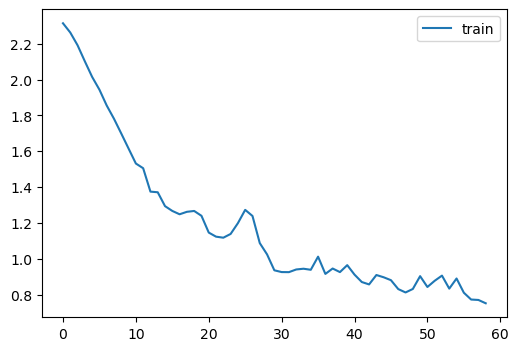

In [43]:
learn.fit(1)

We now have a nice working flexible learner, which we can understand its training Loop.
We can use a framework which we control and can make it work how we want to.
Ideally not by changing the learner itself, but by creating callbacks.
We haven't added inference yet, but that shouldn't be too much to add.

Python is so flexible that when we said `self.predict self.get self.lost`,
if they don't exist then it's going to use `__getatrr__` 
and it's going to try to find those in the callbacks.
We could have multiple callbacks that define these things and then chain them together.

## TrainLearner and MomentumLearner

In [44]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

The learner isn't doing anything that it wasn't doing before, but
now if we want to use huggingface accelerate, 
or something that works on huggingface data Styles, dictionary things, etc.,
we can change how it behaves, by creating a callback for training like `TrainCB`.
And if we want everything except one thing to be the same, we can inherit from `TrainCB`.

In [45]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.653,1.029,0,train
0.790,0.577,0,eval


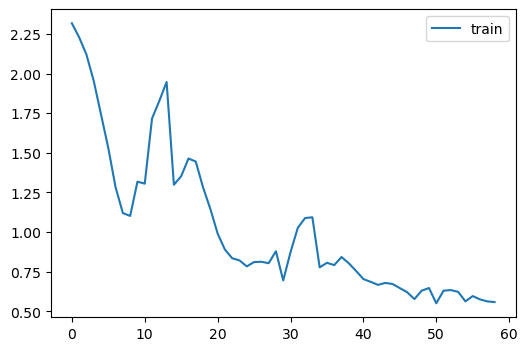

In [46]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

### TrainingLearner subclass

There's another way we could make these exist: we could subclass `Learner`.
Let's not use `trainCB` just to show us how a subclass would work.
We subclass `Learner` and define the 5 methods directly in the subclass.
This way it's never going to end up going to `__getattr__` 
(which is only called if something doesn't exist).
All these five are exactly the same as in `TrainCB`, but we don't need self.learn anymore, because we are in the learner, so self. suffices.

We copy and paste all those, add mom=0.85, and call Super().
*make sure to call the super classes passing in all the stuff*.
We could use delegates for this.

Normally for momentum we have to store a complete copy of all the gradients, 
to keep track of a running exponentially waited moving average.
But using this "trick" we're using the `.grad` themselves to store the
exponentially weighted moving average, obtining an accelerated optimizers and memory savings.

Also changed `zero_grad` 
*to do something a bit crazy not sure if this has been done before*.
`zero_grad` we call after we take the optimizer step.
Pytorch always adds the gradients to the existing gradients and that's why we normally have to call zero_grad.
But, we doesn't actually have to zero the gradients.
Instead we can multiply the gradients by some constant number, e.g.,  0.85.
Our previous gradients would still be there, but they would be reduced a bit.
Lets try it:

Still trains but there's no trainCB callback anymore in the list.
We don't need one because it finds the 5 methods in the subclass now.
This is training at the same learning rate for the same time, and the accuracy improves.
*This is a lot like gradient accumulation callback*
Loss improved from 0.8 to 0.55 and the accuracy from 0.7 to 0.8.
We have just implemented momentum, which can make us reach the destination faster.

## LRFinderCB

Another callback is the learning rate finder.
We increase the LR gradually over time, plot the loss against the LR
and find how high can the LR be before the loss starts getting worse.
We want it roughly where the steepest slope is, below about 0.1.

An LRfinder needs to know how much to multiply the LR by each batch, 
e.g., 30%, `lr_mult=1.3`.
Before we fit we need to keep track of what we put on a plot: LRs and losses. 
We have to decide when do we stop training, when it has clearly gone off the rails.
JH decided that if the loss is 3 times higher than the minimum loss we've seen then we stop.
We keep track of the minimum loss (`self.min`), initially set to Infinity (`math.inf`).

If we're not training then we don't want to do anything,
(we don't use the LRfinder during validation), so we raise `CancelEpochException()`,
which stops it from doing that epoch entirely.
`one_epoch` does with the Callback context manager Epoch, 
and that will say "got canceled" so it goes straight to the
`except` which goes to the end of that code and it's going to skip it.

Pytorch stores the LRs inside the optimizer in `param_groups`. 
We can grab the LR from that dictionary.
We've got to keep track of the loss, so append it to our list of losses,
and if it's less than the minimum we've seen then record it as the minimum.
If it's greater than 3 times the minimum, then raise the `cancelFitexception` to stop everything.
Finally we've got to update our learning rate to 1.3 times the previous one.
In Pytorch we have to go through each `param_group`, grab the LR in the dictionary and multiply it.

In [47]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

The `LRFinder` callback needs to be instantiated first, to be able to grab its learning rates 
and its losses.

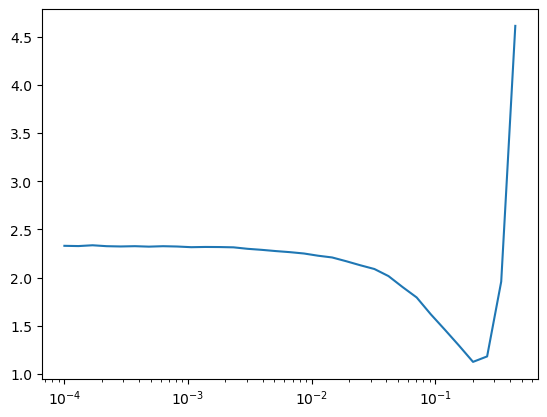

In [48]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

We could implement this with a Pytorch learning rate scheduler, but it won't save much.
The Pytorch LR scheduler basically does this one line of code for us:
```Python
 for g in self.learn.opt.param_groups: g['lr'] *= self.lr_mult
```
Lets create a new LRfinderCB, using the Pytorch `ExponentialLR ` scheduler.

NB: *the documentation of this is wrong it claims that it decays the learning
rate of each parameter Group by gamma, just some number you pass in.
It says every epoch but it's not actually done every Epoch.
In Pytorch the schedulers have a step method and the Decay happens each time you call step.
If you set gamma (actually LRmult) to a number bigger than 1,
it's not a Decay it's an increase.*

In [49]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

The main difference here is that `before_fit` we're going to create a `self.shed`
```Python
self.sched = ExponentialLR(self.learn.opt, self.gamma)
```
equal to the scheduler because it's going to be adjusting the learning rates.
It needs access to the optimizer and the learning rate multiplier.
`After_batch` rather than having 
```Python
 for g in self.learn.opt.param_groups: g['lr'] *= self.lr_mult
```
we replace it with this line of code: `self.shed.step()`.

We're not gaining much by using the Pytorch ExponentialLR scheduler.
Pytorch schedulers are not doing anything magic, just that one line of code for us.

In [50]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*self.max_mult:
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

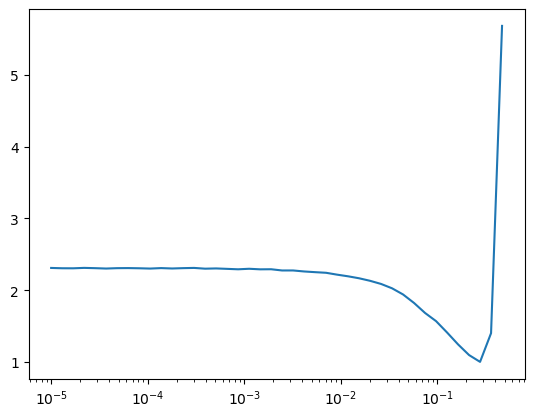

In [51]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

<span style='color:Blue'>
Calling the LRfinder is now easier because we added a `@patch` to the learner
`@fc.patch` decorator lets you take a function and it will turn that function into a method 
of the class we put after the colon (here `Learner`).
This has created a new method called `lr_find` or `Learner.lr_find'.
`lr_find` calls `self.fit` where `self` is a `learner`,
passing in `max_epochs` as maximum number of epochs, 
what to start the learning rate 'start_lr`, 
and to use as `cbs` callbacks the LRFinderCB` callback.
</span>

In [52]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

`lr_find` was added in lesson 18. It's just a shorter way of using `LRFinderCB`.
`@patch` 
<span style='color:Blue'> is a very convenient thing. 
Python has a lot of "folk wisdom" about what is and isn't considered "pythonic" or good.
A lot of people don't like patching.
In other languages it's used very widely and is considered good.
JH doesn't have strong opinions either way about what's good or what's bad.
In this situation it's very nice to be able to add in this additional functionality to our class.
    </span>

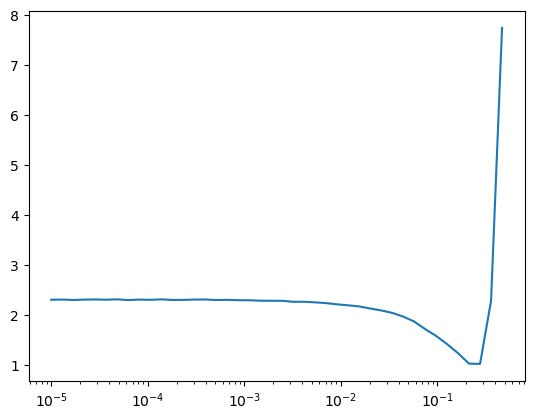

In [53]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

## Export -

In [54]:
import nbdev; nbdev.nbdev_export()